In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [3]:
def image_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Code

In [7]:
from utils.resourceloader import ResourceLoader

from pianovision.keyboard.data import Keyboard
from pianovision.keyboard.masking import KeyboardMasking

from pianovision.keyboard.func.detector import KeyboardDetector
from pianovision.keyboard.func.firstkey import FirstBlackKeyRecognition

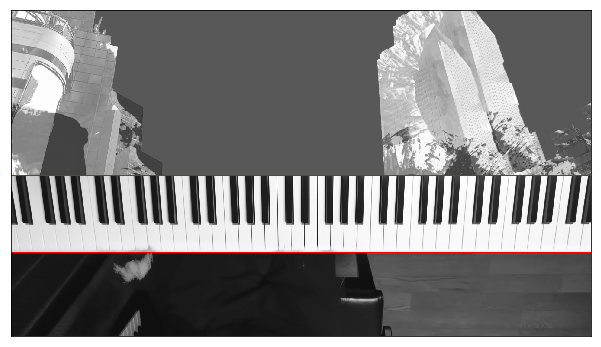

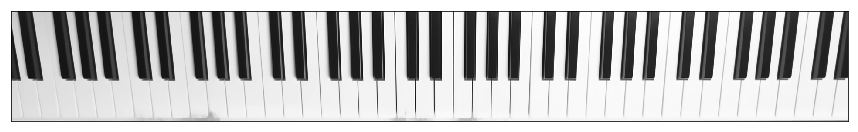

In [8]:
img_id = 0
imgs = [
    {
        "name": "flamingo",
        "crop": (550, 804)
    },
    {
        "name": "believer",
        "crop": (514, 726)
    }
]

resource = ResourceLoader(imgs[img_id]["name"])
keyboard = Keyboard(resource)
keyboard.loadImage(auto=False)

image = keyboard.image

# Marcar corte
hi, hf = imgs[img_id]["crop"]

cropped_preview = image.copy()
cv2.line(cropped_preview, (0, hi), (w-1, hi), (0, 0, 255), 3)
cv2.line(cropped_preview, (0, hf), (w-1, hf), (0, 0, 255), 3)

image_plot(cv2.cvtColor(cropped_preview, cv2.COLOR_BGR2RGB))

keyboard.cropped = cropped = image[hi:hf,:]

image_plot(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

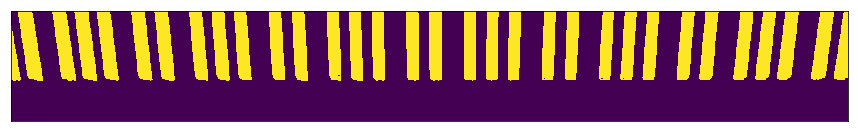

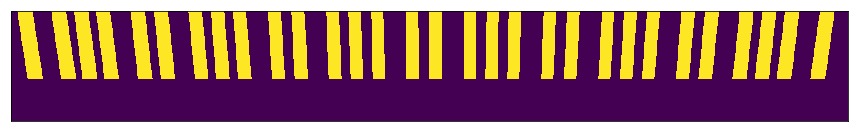

159
D#


In [10]:
KeyboardMasking(keyboard)

image_plot(keyboard.mask.thresh)
image_plot(keyboard.mask.mask)

print(keyboard.mask.vlimit)

first_black_keys = FirstBlackKeyRecognition(keyboard.mask.mask[int(keyboard.mask.vlimit/2), :])
print(first_black_keys.first_key_label)